# Peter at ang Lobo: Primer sa Reinforcement Learning

Sa tutorial na ito, matututuhan natin kung paano gamitin ang Reinforcement Learning sa isang problema ng paghahanap ng daan. Ang setting ay inspirasyon mula sa [Peter and the Wolf](https://en.wikipedia.org/wiki/Peter_and_the_Wolf), isang musikal na kuwentong-pambata ng Russian composer na si [Sergei Prokofiev](https://en.wikipedia.org/wiki/Sergei_Prokofiev). Ito ay kuwento tungkol sa batang si Peter, isang matapang na pioneer na lumabas ng kanyang bahay patungo sa clearing ng kagubatan upang habulin ang lobo. Magtuturo tayo ng mga algorithm sa machine learning na tutulong kay Peter na galugarin ang paligid at bumuo ng pinakamainam na mapa ng pag-navigate.

Una, mag-import tayo ng ilang kapaki-pakinabang na mga library:


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math

## Pangkalahatang-ideya ng Reinforcement Learning

Ang **Reinforcement Learning** (RL) ay isang teknik sa pag-aaral na nagbibigay-daan sa atin na matutunan ang pinakamainam na kilos ng isang **agent** sa isang **kapaligiran** sa pamamagitan ng pagsasagawa ng maraming eksperimento. Ang isang agent sa kapaligirang ito ay dapat mayroong isang **layunin**, na tinutukoy ng isang **reward function**.

## Ang Kapaligiran

Para sa kasimplehan, isipin natin na ang mundo ni Peter ay isang parisukat na board na may sukat na `width` x `height`. Ang bawat cell sa board na ito ay maaaring:
* **lupa**, kung saan maaaring maglakad si Peter at ang iba pang nilalang
* **tubig**, kung saan malinaw na hindi ka maaaring maglakad
* **isang puno** o **damo** - isang lugar kung saan maaari kang magpahinga
* **isang mansanas**, na kumakatawan sa isang bagay na ikatutuwa ni Peter na makita upang makakain siya
* **isang lobo**, na mapanganib at dapat iwasan

Upang makipag-ugnayan sa kapaligiran, magtatakda tayo ng isang klase na tinatawag na `Board`. Upang hindi masyadong magulo ang notebook na ito, inilipat namin ang lahat ng code na may kinalaman sa board sa isang hiwalay na module na tinatawag na `rlboard`, na ating i-import ngayon. Maaari mong tingnan ang loob ng module na ito upang makakuha ng higit pang detalye tungkol sa mga panloob na aspeto ng implementasyon.


In [2]:
from rlboard import *

Ngayon, gumawa tayo ng random na board at tingnan kung ano ang itsura nito:


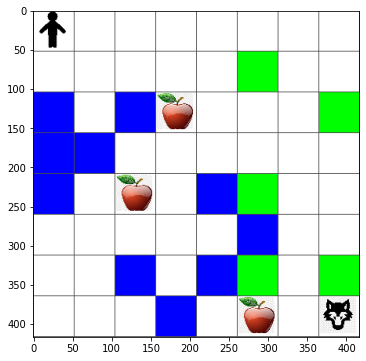

In [3]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

## Mga Aksyon at Patakaran

Sa ating halimbawa, ang layunin ni Peter ay makahanap ng mansanas habang iniiwasan ang lobo at iba pang mga hadlang. Para magawa ito, maaari siyang maglakad-lakad hanggang sa makita niya ang mansanas. Kaya, sa anumang posisyon, maaari siyang pumili mula sa isa sa mga sumusunod na aksyon: pataas, pababa, kaliwa, at kanan. Ipapakahulugan natin ang mga aksyon na ito bilang isang diksyunaryo, at iuugnay ang mga ito sa mga pares ng kaukulang pagbabago sa koordinasyon. Halimbawa, ang paggalaw pakanan (`R`) ay tumutukoy sa isang pares `(1,0)`.


In [4]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

Ang estratehiya ng ating ahente (Peter) ay tinutukoy ng tinatawag na **patakaran**. Tingnan natin ang pinakasimpleng patakaran na tinatawag na **random walk**.

## Random walk

Unahin nating lutasin ang ating problema sa pamamagitan ng pagpapatupad ng estratehiyang random walk.


In [5]:
def random_policy(m):
    return random.choice(list(actions))

def walk(m,policy,start_position=None):
    n = 0 # number of steps
    # set initial position
    if start_position:
        m.human = start_position 
    else:
        m.random_start()
    while True:
        if m.at() == Board.Cell.apple:
            return n # success!
        if m.at() in [Board.Cell.wolf, Board.Cell.water]:
            return -1 # eaten by wolf or drowned
        while True:
            a = actions[policy(m)]
            new_pos = m.move_pos(m.human,a)
            if m.is_valid(new_pos) and m.at(new_pos)!=Board.Cell.water:
                m.move(a) # do the actual move
                break
        n+=1

walk(m,random_policy)

18

Subukan nating patakbuhin ang random walk na eksperimento nang ilang beses at tingnan ang karaniwang bilang ng mga hakbang na ginawa:


In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        else:
            s += z
            n += 1
    print(f"Average path length = {s/n}, eaten by wolf: {w} times")

print_statistics(random_policy)

Average path length = 32.87096774193548, eaten by wolf: 7 times


## Gantimpalang Function

Upang gawing mas matalino ang ating polisiya, kailangan nating maunawaan kung alin sa mga galaw ang "mas mabuti" kaysa sa iba.


In [7]:
move_reward = -0.1
goal_reward = 10
end_reward = -10

def reward(m,pos=None):
    pos = pos or m.human
    if not m.is_valid(pos):
        return end_reward
    x = m.at(pos)
    if x==Board.Cell.water or x == Board.Cell.wolf:
        return end_reward
    if x==Board.Cell.apple:
        return goal_reward
    return move_reward

## Q-Learning

Gumawa ng Q-Table, o multi-dimensional na array. Dahil ang ating board ay may sukat na `width` x `height`, maaari nating i-representa ang Q-Table gamit ang isang numpy array na may hugis na `width` x `height` x `len(actions)`:


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

Ilagay ang Q-Table sa plot function upang maipakita ang talahanayan sa board:


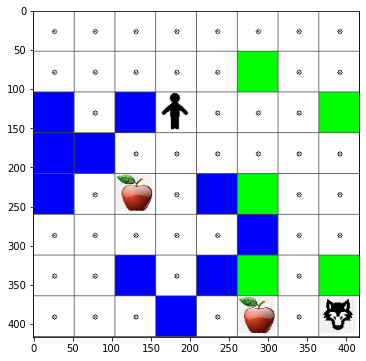

In [9]:
m.plot(Q)

## Ang Diwa ng Q-Learning: Bellman Equation at Algorithm ng Pagkatuto

Sumulat ng pseudo-code para sa ating algorithm ng pagkatuto:

* I-initialize ang Q-Table Q na may pantay-pantay na halaga para sa lahat ng estado at aksyon
* Itakda ang learning rate $\alpha\leftarrow 1$
* Ulitin ang simulation nang maraming beses
   1. Magsimula sa random na posisyon
   1. Ulitin
        1. Pumili ng aksyon $a$ sa estado $s$
        2. Isagawa ang aksyon sa pamamagitan ng paglipat sa bagong estado $s'$
        3. Kung makatagpo ng kondisyon ng pagtatapos ng laro, o masyadong mababa ang kabuuang gantimpala - itigil ang simulation  
        4. Kalkulahin ang gantimpala $r$ sa bagong estado
        5. I-update ang Q-Function ayon sa Bellman equation: $Q(s,a)\leftarrow (1-\alpha)Q(s,a)+\alpha(r+\gamma\max_{a'}Q(s',a'))$
        6. $s\leftarrow s'$
        7. I-update ang kabuuang gantimpala at bawasan ang $\alpha$.

## Pagsamantala vs. Paggalugad

Ang pinakamainam na diskarte ay ang balansehin ang pagitan ng paggalugad at pagsamantala. Habang mas natututo tayo tungkol sa ating kapaligiran, mas malamang na sundan natin ang pinakamainam na ruta, ngunit paminsan-minsan ay pumili ng hindi pa nasusubukang landas.

## Implementasyon sa Python

Ngayon ay handa na tayong ipatupad ang algorithm ng pagkatuto. Bago iyon, kailangan din natin ng isang function na magko-convert ng arbitraryong mga numero sa Q-Table sa isang vector ng mga probabilidad para sa mga kaukulang aksyon:


In [10]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

Nagdadagdag kami ng maliit na halaga ng `eps` sa orihinal na vector upang maiwasan ang paghahati sa 0 sa unang kaso, kung saan lahat ng bahagi ng vector ay magkapareho.

Ang aktwal na algorithm ng pag-aaral na tatakbuhin namin para sa 5000 na eksperimento, na tinatawag ding **epochs**:


In [11]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    m.random_start()
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        dpos = actions[a]
        m.move(dpos,check_correctness=False) # we allow player to move outside the board, which terminates episode
        r = reward(m)
        cum_reward += r
        if r==end_reward or cum_reward < -1000:
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

Pagkatapos isagawa ang algorithm na ito, ang Q-Table ay dapat ma-update ng mga halaga na naglalarawan sa kaakit-akit ng iba't ibang aksyon sa bawat hakbang. Ipakita ang talahanayan dito:


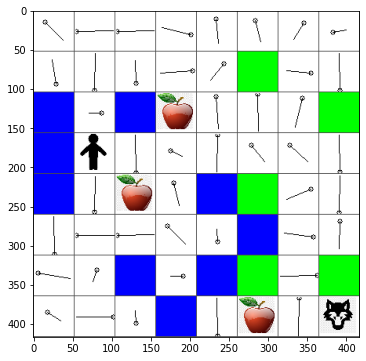

In [12]:
m.plot(Q)

## Pag-check ng Patakaran

Dahil inililista ng Q-Table ang "kaakit-akit" ng bawat aksyon sa bawat estado, madali itong gamitin upang tukuyin ang epektibong pag-navigate sa ating mundo. Sa pinakasimpleng kaso, maaari lang nating piliin ang aksyon na tumutugma sa pinakamataas na halaga ng Q-Table:


In [13]:
def qpolicy_strict(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = list(actions)[np.argmax(v)]
        return a

walk(m,qpolicy_strict)

2

Kung susubukan mo ang code sa itaas nang ilang beses, mapapansin mo na minsan ito ay parang "tumitigil" lang, at kailangan mong pindutin ang STOP button sa notebook upang ihinto ito.

> **Gawain 1:** Baguhin ang `walk` function upang limitahan ang maximum na haba ng path sa isang tiyak na bilang ng hakbang (halimbawa, 100), at obserbahan ang code sa itaas na ibalik ang halagang ito paminsan-minsan.

> **Gawain 2:** Baguhin ang `walk` function upang hindi ito bumalik sa mga lugar na dati na nitong napuntahan. Maiiwasan nito ang `walk` na mag-loop, gayunpaman, maaaring ma-"trap" pa rin ang agent sa isang lokasyon kung saan hindi na ito makakaalis.


In [14]:

def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Average path length = 3.45, eaten by wolf: 0 times


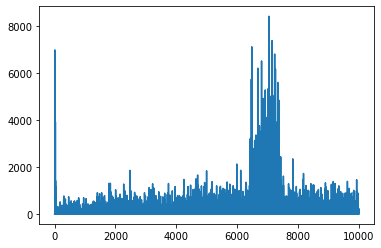

In [15]:
plt.plot(lpath)

Ang ating nakikita dito ay sa simula, ang average na haba ng landas ay tumaas. Malamang ito ay dahil sa katotohanang kapag wala tayong alam tungkol sa kapaligiran, mas malaki ang posibilidad na maipit tayo sa mga hindi magagandang estado, tulad ng tubig o lobo. Habang natututo tayo at nagsisimulang gamitin ang kaalamang ito, mas nagiging posible na tuklasin ang kapaligiran nang mas matagal, ngunit hindi pa rin natin alam nang husto kung nasaan ang mga mansanas.

Kapag sapat na ang ating natutunan, mas nagiging madali para sa ahente na maabot ang layunin, at ang haba ng landas ay nagsisimulang bumaba. Gayunpaman, bukas pa rin tayo sa pagtuklas, kaya madalas tayong lumilihis mula sa pinakamainam na landas at sinusubukan ang mga bagong opsyon, na nagiging sanhi ng paghabang muli ng landas kaysa sa optimal.

Isa pang napansin natin sa grap na ito ay sa isang punto, biglang tumaas ang haba. Ipinapakita nito ang stochastic na kalikasan ng proseso, at na sa ilang pagkakataon, maaaring "masira" ang mga coefficient ng Q-Table sa pamamagitan ng pag-overwrite ng mga ito gamit ang mga bagong halaga. Dapat itong mabawasan sa pamamagitan ng pagpapababa ng learning rate (halimbawa, sa dulo ng pagsasanay, ina-adjust lamang natin ang mga halaga ng Q-Table nang kaunti).

Sa kabuuan, mahalagang tandaan na ang tagumpay at kalidad ng proseso ng pagkatuto ay malaki ang nakadepende sa mga parameter, tulad ng learning rate, learning rate decay, at discount factor. Ang mga ito ay madalas tawaging **hyperparameters**, upang maiba mula sa **parameters** na ina-optimize natin habang nagsasanay (halimbawa, mga coefficient ng Q-Table). Ang proseso ng paghahanap ng pinakamahusay na mga halaga ng hyperparameter ay tinatawag na **hyperparameter optimization**, at ito ay nararapat na talakayin bilang isang hiwalay na paksa.


## Ehersisyo
#### Isang Mas Realistikong Mundo ng Peter at ang Lobo

Sa ating sitwasyon, si Peter ay nakakapaglakad-lakad halos nang hindi napapagod o nagugutom. Sa isang mas realistiko na mundo, kailangan niyang umupo at magpahinga paminsan-minsan, at kailangan din niyang kumain. Gawin nating mas makatotohanan ang ating mundo sa pamamagitan ng pagsasagawa ng mga sumusunod na patakaran:

1. Sa bawat paglipat ni Peter mula sa isang lugar patungo sa iba pa, nawawalan siya ng **enerhiya** at nagkakaroon ng **pagkapagod**.
2. Makakakuha si Peter ng mas maraming enerhiya sa pamamagitan ng pagkain ng mansanas.
3. Mawawala ang pagkapagod ni Peter sa pamamagitan ng pagpapahinga sa ilalim ng puno o sa damuhan (hal., paglalakad papunta sa isang lokasyon sa board na may puno o damo - berdeng bahagi).
4. Kailangan hanapin at patayin ni Peter ang lobo.
5. Upang mapatay ang lobo, kailangang may sapat na antas ng enerhiya at mababang pagkapagod si Peter, kung hindi ay matatalo siya sa laban.

Baguhin ang reward function sa itaas ayon sa mga patakaran ng laro, patakbuhin ang reinforcement learning algorithm upang matutunan ang pinakamainam na estratehiya para manalo sa laro, at ikumpara ang resulta ng random walk sa iyong algorithm batay sa dami ng mga larong napanalunan at natalo.

> **Note**: Maaaring kailanganin mong i-adjust ang mga hyperparameter upang gumana ito, lalo na ang bilang ng mga epochs. Dahil ang tagumpay sa laro (pakikipaglaban sa lobo) ay isang bihirang pangyayari, maaari mong asahan ang mas mahabang oras ng pagsasanay.



---

**Paunawa**:  
Ang dokumentong ito ay isinalin gamit ang AI translation service na [Co-op Translator](https://github.com/Azure/co-op-translator). Bagama't sinisikap naming maging tumpak, pakitandaan na ang mga awtomatikong pagsasalin ay maaaring maglaman ng mga pagkakamali o hindi pagkakatugma. Ang orihinal na dokumento sa orihinal nitong wika ang dapat ituring na opisyal na sanggunian. Para sa mahalagang impormasyon, inirerekomenda ang propesyonal na pagsasalin ng tao. Hindi kami mananagot sa anumang hindi pagkakaunawaan o maling interpretasyon na maaaring magmula sa paggamit ng pagsasaling ito.
